# Effect of Regularization on Neural Networks
If you suspect your neural network is **overfitting** your data (high variance), one of the first strategies to consider is probably **regularization**.

In this notebook I will implement two common regularization methods:
- L2 regularization
- Dropout

## L2 Regularization
L2 regularization introduces a hyperparameter $\lambda$ that can be tuned to control its effect on the model. $\lambda$ is called **regularization parameter**.
The new cost function will be the following:
$$J(w^{[1]}, b^{[1]}, ..., w^{[L]}, b^{[L]}) = \frac{1}{m}\sum_{i=1}^m\mathcal{L}(\hat{y}^{(1)}, y^{(i)}) + \frac{\lambda}{2m}\sum_{l=1}^L\big|\big|w^{[l]}\big|\big|^2_F$$
where the term:
$$\big|\big|w^{[l]}\big|\big|^2_F = \sum_{i=1}^{n^{[l]}}\sum_{j=1}^{n^{[l-1]}}\big(w_{i,j}^{[l]}\big)^2$$
is called **Frobenius norm**.

Since we are using the Euclidean norm, so we call it L2 regularization.

With this new cost function, the gradient updates also change by incorporating an additional term:
$$dw^{[l]} = (from \: backpropagation) + \frac{\lambda}{m}w^{[l]}$$
During parameters updates:
$$w^{[l]} := w^{[l]} - \alpha \cdot dw^{[l]} = w^{[l]} - \alpha \cdot \frac{\lambda}{m} w^{[l]} - \alpha \cdot (from \: backpropagation)$$

### Why Regularization Reduces Overfitting?
By adding the extra term we penalize the $W$ matrix from being too large, encouraging the weights to be closer to zero. A network with smaller weights is less complex, as neurons tend to compute similar values, leading to similar activations. In this way by having a smaller network it will fit less the data, preventing overfitting.

## Dropout
In dropout we randomly "drop out" a certain percentage of neurons during training. This means that the network will temporary ignore the output of some neurons, simplifying the network.

## In a nutshell
We can think of the network's prediction as a curve bending around the data points. By providing more neurons, those bends can become very detailed, leading to overfitting. By simplifying the network we prevent the network to bend too much next to some data points, reducing overfitting.


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
print("Setup Complete")

Setup Complete


# Dataset
I am using the Iris dataset in order to use a simple dataset and clearly show overfitting by training a small dataset for may epochs.

In [2]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
# Create a DataFrame for easier handling
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y

In [4]:
def preprocess_data(X, y, test_size=0.2, val_size=0.2):
    # Split the data into train+val and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Split the train+val set into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # One-hot encode the target variable
    encoder = OneHotEncoder(sparse_output=False)
    y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
    y_val_encoded = encoder.transform(y_val.reshape(-1, 1))
    y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

    # Transpose the data to match the expected input format (features as rows, examples as columns)
    X_train = X_train_scaled.T
    X_val = X_val_scaled.T
    X_test = X_test_scaled.T
    y_train = y_train_encoded.T
    y_val = y_val_encoded.T
    y_test = y_test_encoded.T

    return X_train, X_val, X_test, y_train, y_val, y_test


In [5]:
# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(X, y)

# Model

In [6]:
class DeepNeuralNetwork():

    def __init__(self,
               layers_dims,
               init_type='random', mini_batch_size=64,
               beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8,
               lambd = 0.7,
               keep_prob = 1.0,
               print_cost=True):

        np.random.seed(3)

        self.parameters = {}
        self.grads = {}
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mini_batch_size = mini_batch_size
        self.lambd = lambd
        self.keep_prob = keep_prob
        self.print_cost = print_cost
        self.dropout_masks = []

        L = len(layers_dims)

        if init_type == 'random':
            for l in range(1, L):
                self.parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 0.01
                self.parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))

        elif init_type == 'he':
            for l in range(1, L):
                self.parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layers_dims[l-1])
                self.parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))


    def random_mini_batches(self, X, Y, seed=0):
        np.random.seed(seed)
        m = X.shape[1]  # number of training examples
        mini_batches = []

        # Shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation]

        # Partition (shuffled_X, shuffled_Y)
        num_complete_minibatches = m // self.mini_batch_size

        for k in range(num_complete_minibatches):
            mini_batch_X = shuffled_X[:, k*self.mini_batch_size : (k+1)*self.mini_batch_size]
            mini_batch_Y = shuffled_Y[:, k*self.mini_batch_size : (k+1)*self.mini_batch_size]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        # Handle the end case (last mini-batch < mini_batch_size)
        if m % self.mini_batch_size != 0:
            mini_batch_X = shuffled_X[:, num_complete_minibatches*self.mini_batch_size :]
            mini_batch_Y = shuffled_Y[:, num_complete_minibatches*self.mini_batch_size :]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        return mini_batches


    def initialize_velocity(self):
        L = len(self.parameters) // 2
        v = {}

        for l in range(1, L+1):
            v['dW' + str(l)] = np.zeros(self.parameters['W' + str(l)].shape)
            v['db' + str(l)] = np.zeros(self.parameters['b' + str(l)].shape)

        return v

    def initialize_rms(self):
        L = len(self.parameters) // 2
        s = {}

        for l in range(1, L+1):
            s['dW' + str(l)] = np.zeros(self.parameters['W' + str(l)].shape)
            s['db' + str(l)] = np.zeros(self.parameters['b' + str(l)].shape)

        return s


    def initialize_adam(self):

        L = len(self.parameters) // 2
        v = {}
        s = {}

        for l in range(1, L + 1):
            v["dW" + str(l)] = np.zeros(self.parameters["W" + str(l)].shape)
            v["db" + str(l)] = np.zeros(self.parameters["b" + str(l)].shape)
            s["dW" + str(l)] = np.zeros(self.parameters["W" + str(l)].shape)
            s["db" + str(l)] = np.zeros(self.parameters["b" + str(l)].shape)

        return v, s


    def update_parameters_momentum(self):
        L = len(self.parameters) // 2

        for l in range(1, L + 1):
            self.v["dW" + str(l)] = self.beta * self.v["dW" + str(l)] + (1 - self.beta) * self.grads["dW" + str(l)]
            self.v["db" + str(l)] = self.beta * self.v["db" + str(l)] + (1 - self.beta) * self.grads["db" + str(l)]
            self.parameters["W" + str(l)] -= self.learning_rate * self.v["dW" + str(l)]
            self.parameters["b" + str(l)] -= self.learning_rate * self.v["db" + str(l)]


    def update_parameters_rms(self):
        L = len(self.parameters) // 2

        for l in range(1, L + 1):
            self.s['dW' + str(l)] = self.beta * self.s['dW' + str(l)] + (1 - self.beta) * self.grads['dW' + str(l)]**2
            self.s['db' + str(l)] = self.beta * self.s['db' + str(l)] + (1 - self.beta) * self.grads['db' + str(l)]**2
            self.parameters['W' + str(l)] -= self.learning_rate * self.grads['dW' + str(l)] / (np.sqrt(self.s['dW' + str(l)]) + self.epsilon)
            self.parameters['b' + str(l)] -= self.learning_rate * self.grads['db' + str(l)] / (np.sqrt(self.s['db' + str(l)]) + self.epsilon)


    def update_parameters_adam(self, t):
        L = len(self.parameters) // 2
        v_corrected = {}
        s_corrected = {}

        for l in range(1, L + 1):
            self.v["dW" + str(l)] = self.beta1 * self.v["dW" + str(l)] + (1 - self.beta1) * self.grads["dW" + str(l)]
            self.v["db" + str(l)] = self.beta1 * self.v["db" + str(l)] + (1 - self.beta1) * self.grads["db" + str(l)]

            v_corrected["dW" + str(l)] = self.v["dW" + str(l)] / (1 - self.beta1**t)
            v_corrected["db" + str(l)] = self.v["db" + str(l)] / (1 - self.beta1**t)

            self.s["dW" + str(l)] = self.beta2 * self.s["dW" + str(l)] + (1 - self.beta2) * np.square(self.grads["dW" + str(l)])
            self.s["db" + str(l)] = self.beta2 * self.s["db" + str(l)] + (1 - self.beta2) * np.square(self.grads["db" + str(l)])

            s_corrected["dW" + str(l)] = self.s["dW" + str(l)] / (1 - self.beta2**t)
            s_corrected["db" + str(l)] = self.s["db" + str(l)] / (1 - self.beta2**t)

            self.parameters["W" + str(l)] -= self.learning_rate * v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + self.epsilon)
            self.parameters["b" + str(l)] -= self.learning_rate * v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + self.epsilon)


    def compute_cost(self, AL, Y):
        m = Y.shape[1]
        AL = np.clip(AL, self.epsilon, 1 - self.epsilon)
        cost = -1/m * np.sum(Y * np.log(AL))
        return cost


    def compute_cost_regularization(self, AL, Y):
        m = Y.shape[1]

        cross_entropy_cost = self.compute_cost(AL, Y)

        L2_regularization_cost = 0.0
        for l in range(1, len(self.parameters) // 2 + 1):
            L2_regularization_cost += np.sum(np.square(self.parameters['W' + str(l)]))

        L2_regularization_cost = (self.lambd / (2 * m)) * L2_regularization_cost

        cost = cross_entropy_cost + L2_regularization_cost

        return cost

    def linear_forward(self, A, W, b):
        Z = np.dot(W, A) + b
        cache = (A, W, b)
        return Z, cache


    def sigmoid(self, Z):
        A = 1/(1+np.exp(-Z))
        cache = Z
        return A, cache


    def relu(self, Z):
        A = np.maximum(0, Z)
        cache = Z
        return A, cache

    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=0, keepdims=True), Z


    def linear_activation_forward(self, A_prev, W, b, activation):
        if activation == 'sigmoid':
            Z, linear_cache = self.linear_forward(A_prev, W, b)
            A, activation_cache = self.sigmoid(Z)

        elif activation == 'relu':
            Z, linear_cache = self.linear_forward(A_prev, W, b)
            A, activation_cache = self.relu(Z)

        elif activation == 'softmax':
            Z, linear_cache = self.linear_forward(A_prev, W, b)
            A, activation_cache = self.softmax(Z)

        cache = (linear_cache, activation_cache)
        return A, cache


    def forward_propagation(self, X):
        caches = []
        A = X
        L = len(self.parameters) // 2
        self.dropout_masks = []

        for l in range(1, L):
            A_prev = A
            A, cache = self.linear_activation_forward(A_prev, self.parameters['W' + str(l)], self.parameters['b' + str(l)], 'relu')

            # Dropout
            D = np.random.rand(*A.shape) < self.keep_prob
            A = np.multiply(A, D)
            A = A / self.keep_prob
            self.dropout_masks.append(D)

            caches.append(cache)
            #print(f"Layer {l} - Activation shape: {A.shape}, Dropout mask shape: {D.shape}")

        AL, cache = self.linear_activation_forward(A, self.parameters['W' + str(L)], self.parameters['b' + str(L)], 'softmax')
        caches.append(cache)

        return AL, caches


    def backward_propagation(self, AL, Y, caches):
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)

        # Initializing the backpropagation
        AL = np.clip(AL, self.epsilon, 1 - self.epsilon)
        dAL = AL - Y

        current_cache = caches[L-1]
        dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(dAL, current_cache, "sigmoid")
        self.grads["dA" + str(L-1)] = dA_prev_temp
        self.grads["dW" + str(L)] = dW_temp + (self.lambd / m) * self.parameters["W" + str(L)]
        self.grads["db" + str(L)] = db_temp

        # Loop from l=L-2 to l=0
        for l in reversed(range(L-1)):
            current_cache = caches[l]

            # Apply Dropout Mask
            dA_prev_temp = np.multiply(dA_prev_temp, self.dropout_masks[l])
            dA_prev_temp = dA_prev_temp / self.keep_prob

            dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(self.grads["dA" + str(l + 1)], current_cache, "relu")

            self.grads["dA" + str(l)] = dA_prev_temp
            self.grads["dW" + str(l + 1)] = dW_temp + (self.lambd/m) * self.parameters['W' + str(l + 1)]
            self.grads["db" + str(l + 1)] = db_temp

            #print(f"Layer {l+1} - dA_prev_temp shape: {dA_prev_temp.shape}, Dropout mask shape: {self.dropout_masks[l].shape}")



    def linear_activation_backward(self, dA, cache, activation):
        linear_cache, activation_cache = cache

        if activation == "relu":
            dZ = self.relu_backward(dA, activation_cache)
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)

        elif activation == "sigmoid":
            dZ = self.sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)

        return dA_prev, dW, db


    def linear_backward(self, dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = 1./m * np.dot(dZ, A_prev.T)
        db = 1./m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)

        return dA_prev, dW, db


    def relu_backward(self, dA, cache):
        Z = cache
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        return dZ


    def sigmoid_backward(self, dA, cache):
        Z = cache
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        return dZ


    def compute_accuracy(self, AL, Y):
        y_pred = np.argmax(AL, axis = 0)
        y_true = np.argmax(Y, axis = 0)
        accuracy = np.mean(y_pred == y_true)
        return accuracy


    def fit(self, X, Y, X_val, Y_val, learning_rate=0.001, num_epochs=5000, optimizer='momentum', plot_cost=False, return_data=True):
        self.learning_rate = learning_rate
        costs = []
        val_costs = []
        accuracies = []
        val_accuracies = []
        t = 0
        m = X.shape[1]
        seed = 0

        if optimizer == 'momentum':
            self.v = self.initialize_velocity()
        elif optimizer == 'rms':
            self.s = self.initialize_rms()
        elif optimizer == 'adam':
            self.v, self.s = self.initialize_adam()

        for i in range(num_epochs + 1):
            seed += 1
            minibatches = self.random_mini_batches(X, Y, seed)
            cost_total = 0
            accuracy_total = 0

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch

                AL, caches = self.forward_propagation(minibatch_X)
                cost = self.compute_cost_regularization(AL, minibatch_Y)
                accuracy = self.compute_accuracy(AL, minibatch_Y)
                self.backward_propagation(AL, minibatch_Y, caches)

                if optimizer == 'momentum':
                    self.update_parameters_momentum()
                elif optimizer == 'rms':
                    self.update_parameters_rms()
                elif optimizer == 'adam':
                    t += 1
                    self.update_parameters_adam(t)

                cost_total += cost
                accuracy_total += accuracy

            cost_avg = cost_total / len(minibatches)
            accuracy_avg = accuracy_total / len(minibatches)

            # Compute validation metrics
            AL_val, _ = self.forward_propagation(X_val)
            val_cost = self.compute_cost_regularization(AL_val, Y_val)
            val_accuracy = self.compute_accuracy(AL_val, Y_val)

            if self.print_cost and i % 100 == 0:
                print(f"Epoch {i}: Train Cost: {cost_avg:.4f}, Train Accuracy: {accuracy_avg:.4f}, "
                      f"Val Cost: {val_cost:.4f}, Val Accuracy: {val_accuracy:.4f}")


            if i % 5 == 0:
                costs.append(cost_avg)
                val_costs.append(val_cost)
                accuracies.append(accuracy_avg)
                val_accuracies.append(val_accuracy)


        if plot_cost:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(costs, label='Train')
            plt.plot(val_costs, label='Validation')
            plt.ylabel('Cost')
            plt.xlabel('Epochs (per 5)')
            plt.title(f"Learning rate = {learning_rate}")
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(accuracies, label='Train')
            plt.plot(val_accuracies, label='Validation')
            plt.ylabel('Accuracy')
            plt.xlabel('Epochs (per 5)')
            plt.title(f"Learning rate = {learning_rate}")
            plt.legend()

            plt.tight_layout()
            plt.show()

        if return_data:
            return {'cost': costs,
                    'val_cost': val_costs,
                    'accuracy' :accuracies,
                    'val_accuracy': val_accuracies}

    def predict(self, X):
        AL, _ = self.forward_propagation(X)
        return AL

    def score(self, X, y_true):
        y_pred = self.predict(X)
        accuracy = self.compute_accuracy(y_pred, y_true)
        return accuracy

In [7]:
def evaluate(model, X, Y):
    Y_pred = model.predict(X)
    Y_pred_classes = np.argmax(Y_pred, axis=0)
    Y_true_classes = np.argmax(Y, axis=0)
    accuracy = np.mean(Y_pred_classes == Y_true_classes)
    return accuracy

In [8]:
# Train models with and without regularization
def train_and_evaluate(X_train, X_val, X_test, y_train, y_val, y_test, lambd, keep_prob):
    model = DeepNeuralNetwork(
        layers_dims=[X_train.shape[0], 32, 16, y_train.shape[0]],
        lambd=lambd,
        keep_prob=keep_prob,
        mini_batch_size=32,
        print_cost=False
    )

    train_costs, val_costs, train_accuracies, val_accuracies = model.fit(
        X=X_train, Y=y_train,
        X_val=X_val, Y_val=y_val,
        learning_rate=0.01, num_epochs=1000,
        optimizer='adam', plot_cost=True, return_data=True
    )

    train_accuracy = model.score(X_train, y_train)
    val_accuracy = model.score(X_val, y_val)
    test_accuracy = model.score(X_test, y_test)

    print(f"Train accuracy: {train_accuracy:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")

    return model, train_costs, val_costs, train_accuracies, val_accuracies

# Comparing Model Performance

The following comparison highlights the effects of regularization on neural network training.

### Without Regularization
- Cost: Training cost quickly goes down, but validation cost increases after an initial decline, indicating overfitting.
- Accuracy: Training accuracy reaches 100%, while validation accuracy remains lower and fluctuates, showing poor generalization.

### With Regularization
- Cost: Training cost is higher, but validation cost is more stable, indicating less overfitting.
- Accuracy: Both training and validation accuracy fluctuate more, but they are closer in value, suggesting better generalization.

## Summary
Regularization reduces overfitting, resulting in a model that generalizes better to unseen data, despite not fitting the training data as perfectly.

Training model without regularization:


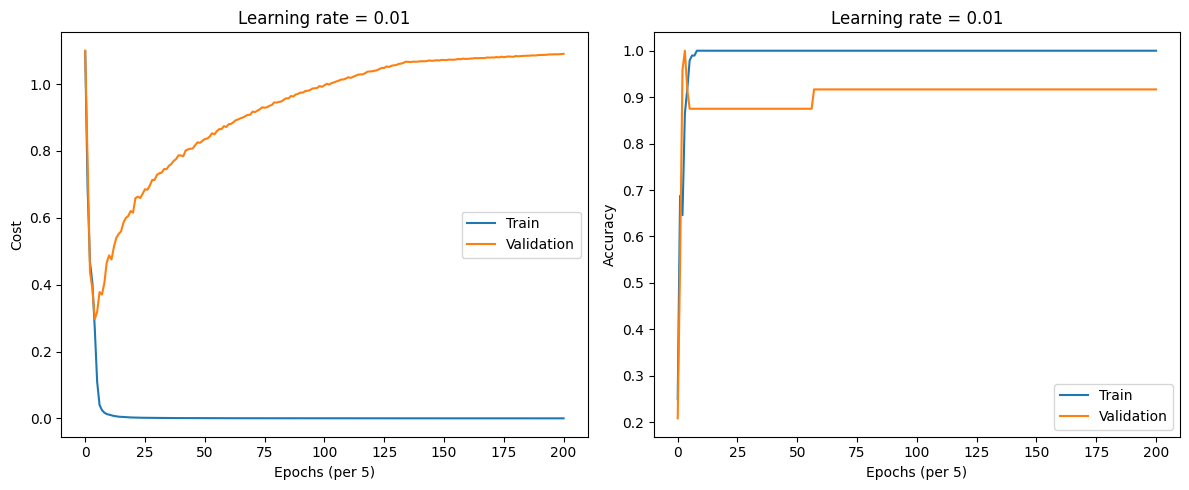

Train accuracy: 1.0000
Validation accuracy: 0.9167
Test accuracy: 0.9333

Training model with regularization:


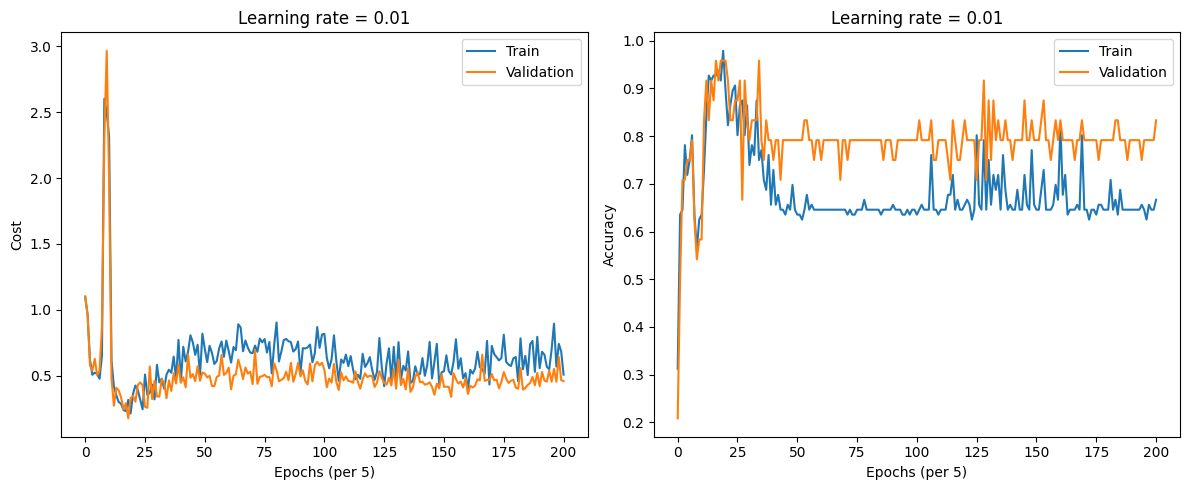

Train accuracy: 0.7292
Validation accuracy: 0.8333
Test accuracy: 0.7000


In [9]:
print("Training model without regularization:")
model_no_reg, costs_no_reg, val_costs_no_reg, acc_no_reg, val_acc_no_reg = train_and_evaluate(
    X_train, X_val, X_test, y_train, y_val, y_test, lambd=0.0, keep_prob=1.0
)

print("\nTraining model with regularization:")
model_reg, costs_reg, val_costs_reg, acc_reg, val_acc_reg = train_and_evaluate(
    X_train, X_val, X_test, y_train, y_val, y_test, lambd=0.1, keep_prob=0.8
)